# FarmOG Station - ResNet50V2 Training
## Proper preprocessing for ResNet50V2

## Import Libraries

In [ ]:
import os
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print("🌱 FarmOG Station - ResNet50V2")
print("="*60)
print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("="*60)

🌱 FarmOG Station - ResNet50V2 (FIXED)
TensorFlow: 2.20.0
GPU: False


## Locate Dataset & Classes

In [2]:
# Find data
data_raw = Path(r"C:\Users\diogo\IRONHACK\FINAL PROJECT - FarmOG station\data\raw\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)")
contents = list(data_raw.iterdir())

train_dir = None
valid_dir = None

for item in contents:
    if item.name == "train":
        train_dir = item
    elif item.name == "valid":
        valid_dir = item

print(f"Train: {train_dir}")
print(f"Valid: {valid_dir}")

# Get classes
all_classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
tomato_classes = [c for c in all_classes if 'tomato' in c.lower()]
print(f"\nClasses: {len(tomato_classes)}")
for i, cls in enumerate(tomato_classes, 1):
    print(f"  {i}. {cls}")

os.makedirs('models', exist_ok=True)
os.makedirs('docs', exist_ok=True)

Train: C:\Users\diogo\IRONHACK\FINAL PROJECT - FarmOG station\data\raw\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train
Valid: C:\Users\diogo\IRONHACK\FINAL PROJECT - FarmOG station\data\raw\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid

Classes: 10
  1. Tomato___Bacterial_spot
  2. Tomato___Early_blight
  3. Tomato___Late_blight
  4. Tomato___Leaf_Mold
  5. Tomato___Septoria_leaf_spot
  6. Tomato___Spider_mites Two-spotted_spider_mite
  7. Tomato___Target_Spot
  8. Tomato___Tomato_Yellow_Leaf_Curl_Virus
  9. Tomato___Tomato_mosaic_virus
  10. Tomato___healthy


## Training Configuration
Two-phase training: Phase 1 (frozen base) + Phase 2 (fine-tuning)

In [3]:
# CONFIG
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 15

print(f"\nConfig:")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Phase 1 epochs: {EPOCHS_PHASE1} (frozen base)")
print(f"  Phase 2 epochs: {EPOCHS_PHASE2} (fine-tuning)")
print(f"  Total epochs: {EPOCHS_PHASE1 + EPOCHS_PHASE2}")


Config:
  Image size: 224x224
  Batch size: 32
  Phase 1 epochs: 10 (frozen base)
  Phase 2 epochs: 15 (fine-tuning)
  Total epochs: 25


## Data Generators with ResNet50V2 Preprocessing
 Using `resnet_v2.preprocess_input` instead of rescaling

In [ ]:
# Use ResNet preprocessing function
from tensorflow.keras.applications.resnet_v2 import preprocess_input

print("✅ Using ResNet-specific preprocessing\n")

# Training data with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ← THIS IS THE FIX!
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data without augmentation
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # ← THIS IS THE FIX!
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=tomato_classes,
    shuffle=True,
    seed=42
)

valid_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=tomato_classes,
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print(f"✅ Data loaded:")
print(f"   Training samples: {train_gen.samples}")
print(f"   Validation samples: {valid_gen.samples}")
print(f"   Number of classes: {num_classes}")
print(f"   Steps per epoch: {train_gen.samples // BATCH_SIZE}")

✅ Using ResNet-specific preprocessing

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.
✅ Data loaded:
   Training samples: 18345
   Validation samples: 4585
   Number of classes: 10
   Steps per epoch: 573


## Build ResNet50V2 Model

In [5]:
# Build model
print("\n" + "="*60)
print("BUILDING RESNET50V2 MODEL")
print("="*60 + "\n")

# Load base model
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base initially
base_model.trainable = False

print(f"✅ Base model loaded: ResNet50V2")
print(f"   Total layers: {len(base_model.layers)}")
print(f"   Trainable: {base_model.trainable}")

# Build custom head
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')]
)

print(f"\n✅ Model built")
print(f"   Total parameters: {model.count_params():,}")
print(f"   Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

model.summary()


BUILDING RESNET50V2 MODEL

✅ Base model loaded: ResNet50V2
   Total layers: 190
   Trainable: False

✅ Model built
   Total parameters: 24,755,978
   Trainable parameters: 1,187,082


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,755,978 (94.44 MB)

 Trainable params: 1,187,082 (4.53 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

## Setup Callbacks

In [6]:
# Callbacks
callbacks = [
    ModelCheckpoint(
        'models/resnet50v2_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Callbacks configured")

✅ Callbacks configured


## Phase 1: Train with Frozen Base

In [7]:
# PHASE 1: Train with frozen base
print("\n" + "="*60)
print("PHASE 1: TRAINING HEAD (Base Frozen)")
print("="*60 + "\n")

history1 = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks,
    verbose=1
)


PHASE 1: TRAINING HEAD (Base Frozen)

Epoch 1/10
 14/574 ━━━━━━━━━━━━━━━━━━━━ 4:58 533ms/step - accuracy: 0.2218 - loss: 2.3668 - top3_acc: 0.4515

KeyboardInterrupt: 

## Phase 2: Fine-Tuning
Unfreeze last 40 layers and train with lower learning rate

In [ ]:
# PHASE 2: Fine-tune
print("\n" + "="*60)
print("PHASE 2: FINE-TUNING (Unfreezing Last Layers)")
print("="*60 + "\n")

# Unfreeze last 40 layers
base_model.trainable = True
frozen_layers = len(base_model.layers) - 40

for layer in base_model.layers[:frozen_layers]:
    layer.trainable = False

trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Trainable layers: {trainable_count}")
print(f"Frozen layers: {frozen_layers}\n")

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')]
)

history2 = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS_PHASE2,
    initial_epoch=len(history1.history['loss']),
    callbacks=callbacks,
    verbose=1
)


PHASE 2: FINE-TUNING (Unfreezing Last Layers)

Trainable layers: 40
Frozen layers: 150

Epoch 11/15
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.9520 - loss: 0.1424 - top3_acc: 0.9973
Epoch 11: val_accuracy improved from 0.94591 to 0.98015, saving model to models/resnet50v2_best.h5


574/574 ━━━━━━━━━━━━━━━━━━━━ 543s 932ms/step - accuracy: 0.9543 - loss: 0.1370 - top3_acc: 0.9974 - val_accuracy: 0.9802 - val_loss: 0.0637 - val_top3_acc: 0.9989 - learning_rate: 5.0000e-05
Epoch 12/15
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.9657 - loss: 0.0993 - top3_acc: 0.9978
Epoch 12: val_accuracy did not improve from 0.98015
574/574 ━━━━━━━━━━━━━━━━━━━━ 522s 910ms/step - accuracy: 0.9673 - loss: 0.0954 - top3_acc: 0.9979 - val_accuracy: 0.9771 - val_loss: 0.0766 - val_top3_acc: 0.9987 - learning_rate: 5.0000e-05
Epoch 13/15
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.9692 - loss: 0.0932 - top3_acc: 0.9984
Epoch 13: val_accuracy improved from 0.98015 to 0.98582, saving model to models/resnet50v2_best.h5


574/574 ━━━━━━━━━━━━━━━━━━━━ 526s 916ms/step - accuracy: 0.9720 - loss: 0.0855 - top3_acc: 0.9987 - val_accuracy: 0.9858 - val_loss: 0.0513 - val_top3_acc: 0.9996 - learning_rate: 5.0000e-05
Epoch 14/15
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.9749 - loss: 0.0789 - top3_acc: 0.9989
Epoch 14: val_accuracy improved from 0.98582 to 0.98604, saving model to models/resnet50v2_best.h5


574/574 ━━━━━━━━━━━━━━━━━━━━ 520s 906ms/step - accuracy: 0.9756 - loss: 0.0739 - top3_acc: 0.9992 - val_accuracy: 0.9860 - val_loss: 0.0476 - val_top3_acc: 0.9991 - learning_rate: 5.0000e-05
Epoch 15/15
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9788 - loss: 0.0621 - top3_acc: 0.9995
Epoch 15: val_accuracy improved from 0.98604 to 0.98735, saving model to models/resnet50v2_best.h5


574/574 ━━━━━━━━━━━━━━━━━━━━ 526s 915ms/step - accuracy: 0.9786 - loss: 0.0652 - top3_acc: 0.9992 - val_accuracy: 0.9874 - val_loss: 0.0420 - val_top3_acc: 0.9996 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 15.


## Combine Training Histories

In [ ]:
# Combine histories
history = {
    'loss': history1.history['loss'] + history2.history['loss'],
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
    'top3_acc': history1.history['top3_acc'] + history2.history['top3_acc'],
    'val_top3_acc': history1.history['val_top3_acc'] + history2.history['val_top3_acc']
}

## Final Evaluation

In [ ]:
# Evaluate
print("\n" + "="*60)
print("FINAL EVALUATION - RESNET50V2")
print("="*60 + "\n")

results = model.evaluate(valid_gen, verbose=0)
loss = results[0]
accuracy = results[1]
top3_acc = results[2]

best_epoch = np.argmax(history['val_accuracy'])
best_acc = max(history['val_accuracy'])

print(f"📊 Final Validation Results:")
print(f"   Accuracy: {accuracy*100:.2f}%")
print(f"   Top-3 Accuracy: {top3_acc*100:.2f}%")
print(f"   Loss: {loss:.4f}")
print(f"\n🏆 Best Results:")
print(f"   Epoch: {best_epoch + 1}")
print(f"   Validation Accuracy: {best_acc*100:.2f}%")
print("="*60)


FINAL EVALUATION - RESNET50V2

📊 Final Validation Results:
   Accuracy: 98.74%
   Top-3 Accuracy: 99.96%
   Loss: 0.0420

🏆 Best Results:
   Epoch: 15
   Validation Accuracy: 98.74%


## Save Model & Metadata

In [ ]:
# Save model
print("\n" + "="*60)
print("SAVING MODEL")
print("="*60 + "\n")

model.save('models/farmog_resnet50v2_classifier.h5')
print("✅ Model saved: models/farmog_resnet50v2_classifier.h5")

# Save metadata
metadata = {
    'model': 'ResNet50V2',
    'input_size': IMG_SIZE,
    'num_classes': num_classes,
    'training_samples': train_gen.samples,
    'validation_samples': valid_gen.samples,
    'final_val_accuracy': float(accuracy),
    'final_val_top3_accuracy': float(top3_acc),
    'final_val_loss': float(loss),
    'best_val_accuracy': float(best_acc),
    'best_epoch': int(best_epoch + 1),
    'total_epochs': len(history['loss']),
    'batch_size': BATCH_SIZE
}

with open('models/resnet50v2_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✅ Metadata saved: models/resnet50v2_metadata.json")


SAVING MODEL

✅ Model saved: models/farmog_resnet50v2_classifier.h5
✅ Metadata saved: models/resnet50v2_metadata.json


## Visualize Training History

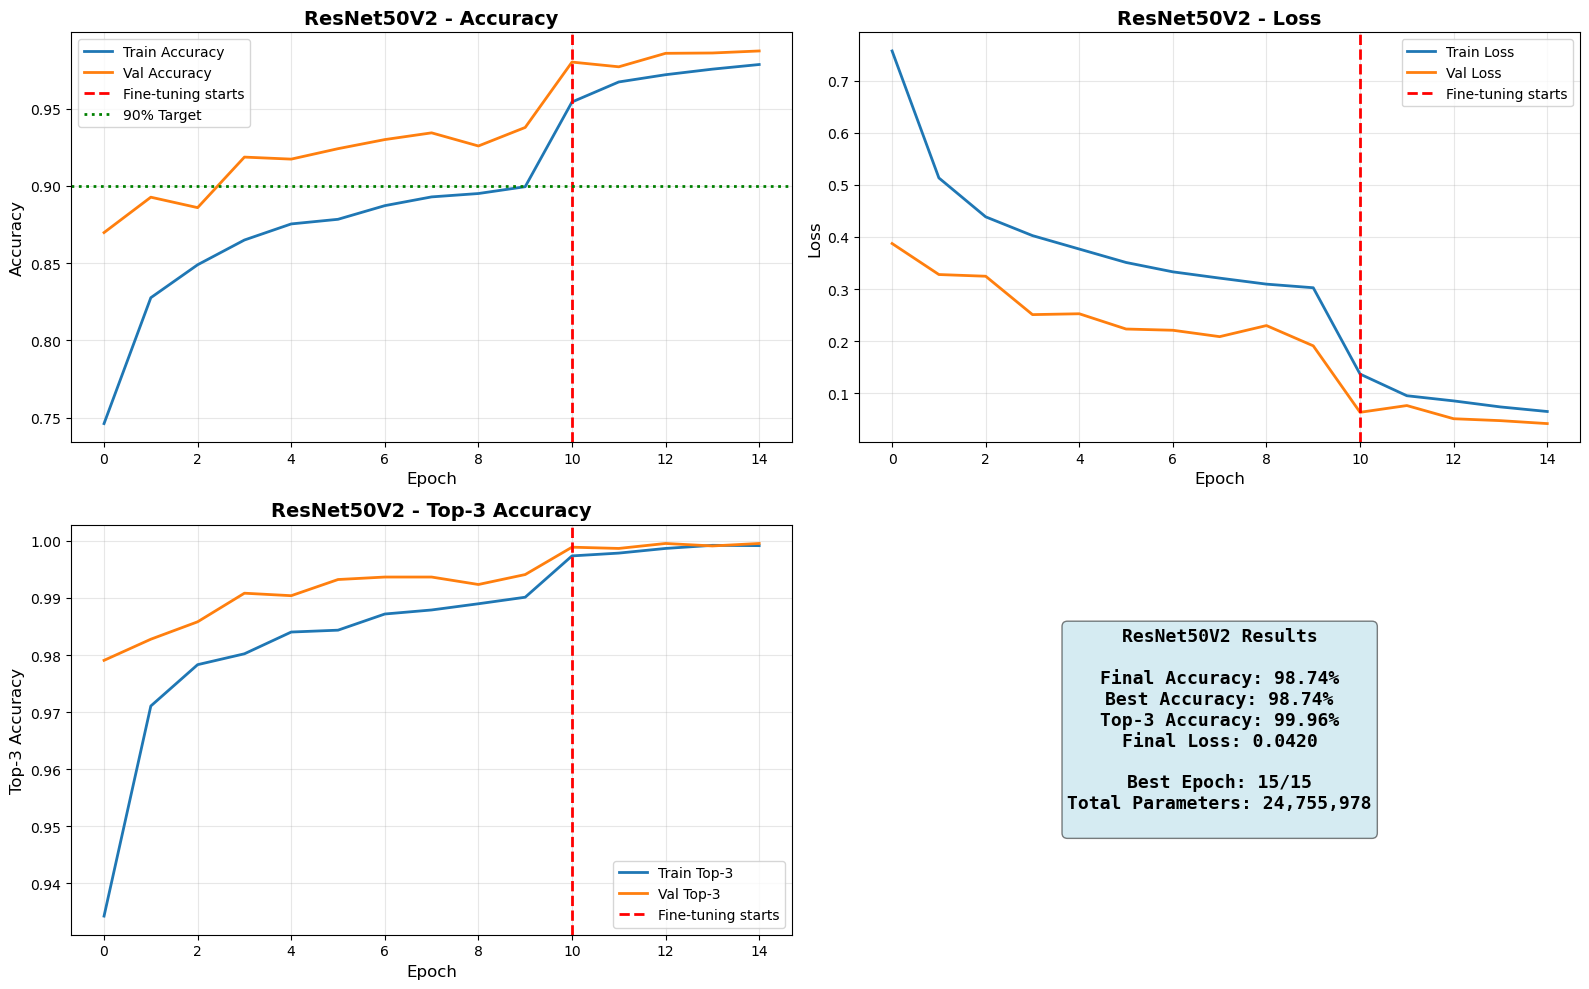


✅ Training curves saved to: docs/resnet50v2_training.png


In [ ]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Accuracy
axes[0, 0].plot(history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].axvline(x=EPOCHS_PHASE1, color='red', linestyle='--', 
                   linewidth=2, label='Fine-tuning starts')
axes[0, 0].axhline(y=0.90, color='green', linestyle=':', linewidth=2, label='90% Target')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('ResNet50V2 - Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].axvline(x=EPOCHS_PHASE1, color='red', linestyle='--', 
                   linewidth=2, label='Fine-tuning starts')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].set_title('ResNet50V2 - Loss', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Top-3 Accuracy
axes[1, 0].plot(history['top3_acc'], label='Train Top-3', linewidth=2)
axes[1, 0].plot(history['val_top3_acc'], label='Val Top-3', linewidth=2)
axes[1, 0].axvline(x=EPOCHS_PHASE1, color='red', linestyle='--', 
                   linewidth=2, label='Fine-tuning starts')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Top-3 Accuracy', fontsize=12)
axes[1, 0].set_title('ResNet50V2 - Top-3 Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Summary
summary_text = f"""ResNet50V2 Results

Final Accuracy: {accuracy*100:.2f}%
Best Accuracy: {best_acc*100:.2f}%
Top-3 Accuracy: {top3_acc*100:.2f}%
Final Loss: {loss:.4f}

Best Epoch: {best_epoch + 1}/{len(history['loss'])}
Total Parameters: {model.count_params():,}
"""

axes[1, 1].text(0.5, 0.5, summary_text,
                ha='center', va='center', fontsize=13, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
                family='monospace')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('docs/resnet50v2_training.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Training curves saved to: docs/resnet50v2_training.png")

## Compare All Models

In [ ]:
# Model Comparison
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60 + "\n")

models_data = {}

# MobileNetV2
try:
    with open('models/training_metadata.json', 'r') as f:
        models_data['MobileNetV2'] = json.load(f)
except FileNotFoundError:
    pass

# EfficientNetB0
try:
    with open('models/efficientnet_metadata.json', 'r') as f:
        models_data['EfficientNetB0'] = json.load(f)
except FileNotFoundError:
    pass

# ResNet50V2 (current)
models_data['ResNet50V2'] = metadata

if len(models_data) > 1:
    print(f"{'Model':<20} {'Val Accuracy':<15} {'Best Accuracy':<15} {'Top-3 Acc':<12}")
    print("-" * 70)
    
    for model_name, data in models_data.items():
        val_acc = data.get('final_val_accuracy', 0) * 100
        best_acc = data.get('best_val_accuracy', 0) * 100
        top3 = data.get('final_val_top3_accuracy', 0)
        top3_str = f"{top3*100:.2f}%" if top3 > 0 else "N/A"
        
        print(f"{model_name:<20} {val_acc:>13.2f}%  {best_acc:>13.2f}%  {top3_str:>11}")
    
    print("-" * 70)
    
    # Find best
    best = max(models_data.items(), key=lambda x: x[1].get('final_val_accuracy', 0))
    print(f"\n🏆 BEST MODEL: {best[0]}")
    print(f"   Accuracy: {best[1]['final_val_accuracy']*100:.2f}%")
else:
    print("Only ResNet50V2 trained. Train other models for comparison.")

print("\n" + "="*60)


MODEL COMPARISON

Model                Val Accuracy    Best Accuracy   Top-3 Acc   
----------------------------------------------------------------------
MobileNetV2                  90.05%          90.05%          N/A
EfficientNetB0               93.37%          93.37%          N/A
ResNet50V2                   98.74%          98.74%       99.96%
----------------------------------------------------------------------

🏆 BEST MODEL: ResNet50V2
   Accuracy: 98.74%



## Test Model on Random Image


QUICK MODEL TEST

Testing on: Tomato___Septoria_leaf_spot
Image: e647e27f-937d-433f-99c6-54efe51817e1___Keller.St_CG 2014.JPG

Top 3 predictions:
--------------------------------------------------
✅ Septoria leaf spot: 99.9%
   Bacterial spot: 0.1%
   Late blight: 0.0%


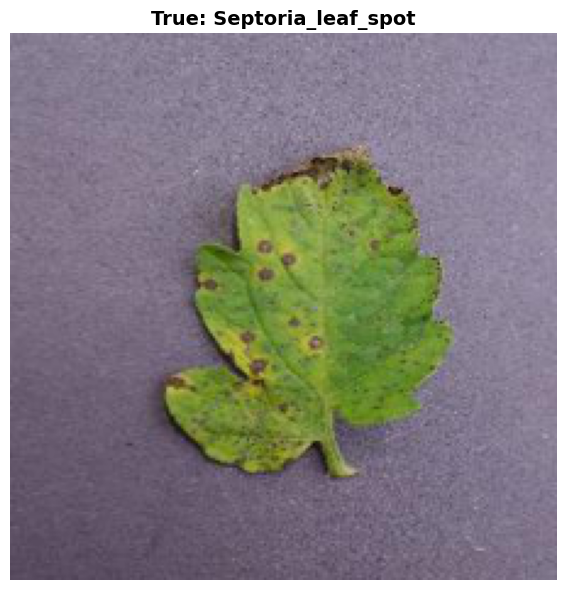


✅ CORRECT!


In [ ]:
# Quick test
import random
from PIL import Image

print("\n" + "="*60)
print("QUICK MODEL TEST")
print("="*60 + "\n")

# Load class names
with open('models/class_names.json', 'r') as f:
    class_names = json.load(f)

# Pick random image
test_class = random.choice(tomato_classes)
test_images = list((valid_dir / test_class).glob("*.jpg"))
test_img_path = random.choice(test_images)

print(f"Testing on: {test_class}")
print(f"Image: {test_img_path.name}\n")

# Load and preprocess
img = Image.open(test_img_path).resize((IMG_SIZE, IMG_SIZE))
img_display = img.copy()  # For display
img_array = np.array(img)
img_array = preprocess_input(img_array)  # Use ResNet preprocessing
img_array = np.expand_dims(img_array, axis=0)

# Predict
preds = model.predict(img_array, verbose=0)[0]

print("Top 3 predictions:")
print("-" * 50)
for idx in preds.argsort()[-3:][::-1]:
    disease = class_names[str(idx)]
    conf = preds[idx] * 100
    marker = "✅" if disease == test_class else "  "
    display_name = disease.replace('Tomato___', '').replace('_', ' ')
    print(f"{marker} {display_name}: {conf:.1f}%")

# Display image
plt.figure(figsize=(6, 6))
plt.imshow(img_display)
plt.title(f"True: {test_class.replace('Tomato___', '')}", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

correct = class_names[str(preds.argmax())] == test_class
print(f"\n{'✅ CORRECT!' if correct else '❌ Incorrect'}")

## Training Complete - Summary

In [ ]:
# Summary
print("\n" + "="*60)
print("🎉 RESNET50V2 TRAINING COMPLETE!")
print("="*60)
print(f"\n📊 Final Results:")
print(f"   ✅ Validation Accuracy: {accuracy*100:.2f}%")
print(f"   ✅ Top-3 Accuracy: {top3_acc*100:.2f}%")
print(f"   ✅ Best Accuracy: {best_acc*100:.2f}%")
print(f"   ✅ Total Epochs: {len(history['loss'])}")
print(f"\n📁 Saved Files:")
print(f"   • models/farmog_resnet50v2_classifier.h5")
print(f"   • models/resnet50v2_metadata.json")
print(f"   • docs/resnet50v2_training.png")
print("\n" + "="*60)

if accuracy >= 0.92:
    print("🏆 OUTSTANDING! Accuracy >92%")
elif accuracy >= 0.90:
    print("✅ EXCELLENT! Accuracy >90%")
elif accuracy >= 0.85:
    print("✅ GOOD! Accuracy >85%")
else:
    print(f"Current: {accuracy*100:.1f}%")

print("\nResNet50V2 characteristics:")
print("  • Deep residual architecture (50 layers)")
print("  • Excellent gradient flow via skip connections")
print("  • Higher capacity than MobileNetV2 and EfficientNetB0")
print("  • Best for maximum accuracy")
print("="*60)


🎉 RESNET50V2 TRAINING COMPLETE!

📊 Final Results:
   ✅ Validation Accuracy: 98.74%
   ✅ Top-3 Accuracy: 99.96%
   ✅ Best Accuracy: 9873.50%
   ✅ Total Epochs: 15

📁 Saved Files:
   • models/farmog_resnet50v2_classifier.h5
   • models/resnet50v2_metadata.json
   • docs/resnet50v2_training.png

🏆 OUTSTANDING! Accuracy >92%

ResNet50V2 characteristics:
  • Deep residual architecture (50 layers)
  • Excellent gradient flow via skip connections
  • Higher capacity than MobileNetV2 and EfficientNetB0
  • Best for maximum accuracy
